In [ ]:
import os
import tensorflow as tf
import zipfile

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


zip_path = '/content/drive/MyDrive/face_glasses_L.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

DATASET_PATH = os.path.join(extract_path, 'face_glasses_L', 'train')

# 載入資料
full_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=DATASET_PATH,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(160,160),
    shuffle=True
)


class_names = full_dataset.class_names
print("Class names:", class_names)  #negative,positive
target_class = 'negative'  #沒戴眼鏡
target_index = class_names.index(target_class)

#過濾出沒有戴眼鏡的圖
filtered = full_dataset.unbatch().filter(lambda x, y: tf.equal(y, target_index))
filtered = filtered.map(lambda x, y: x / 255.0)
filtered_dataset = filtered.batch(32)

Mounted at /content/drive
Found 2290 files belonging to 2 classes.
Class names: ['negative', 'positive']


In [ ]:
def rgb_to_gray(x):
    x = tf.image.rgb_to_grayscale(x)  # 轉成灰階
    x = tf.image.grayscale_to_rgb(x)  # 變成 (H,W,3) 的三通道灰階，符合VGG需求
    return x

# 把你的 dataset 轉灰階
filtered_dataset = filtered_dataset.map(rgb_to_gray)


In [ ]:
import keras
from keras import layers
import tensorflow as tf

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Latent dimension
latent_dim = 128

# --- Encoder ---
encoder_inputs = keras.Input(shape=(160, 160, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(20 * 20 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((20, 20, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # 40x40
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # 80x80
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)   # 160x160
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


# --- VAE model ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Compile the model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(filtered_dataset, epochs=50)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 166ms/step - kl_loss: 22.1708 - loss: 3558.9541 - reconstruction_loss: 3536.7832
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - kl_loss: 81.5218 - loss: 1801.1366 - reconstruction_loss: 1719.6146
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - kl_loss: 109.9670 - loss: 1315.1251 - reconstruction_loss: 1205.1581
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - kl_loss: 126.3244 - loss: 1115.6089 - reconstruction_loss: 989.2845
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - kl_loss: 126.1772 - loss: 1005.9600 - reconstruction_loss: 879.7827
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - kl_loss: 131.2180 - loss: 933.2104 - reconstruction_loss: 801.9924
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - kl_loss: 128.9802 - loss: 860.9385 - reconstruction_loss: 731.9582
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - kl_loss: 130.3662 - loss: 793.5461 - reconstruction_loss: 663.1800
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - kl_loss: 131.4953 - loss: 760.6036 - reconstruction_loss: 629.1084 
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64m

In [ ]:
def show_reconstructions(img_dir, encoder, decoder, num_pairs=8, img_size=(160, 160), save_path=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import random

    assert num_pairs % 4 == 0, "num_pairs must be a multiple of 4 for 4-column layout"

    files = os.listdir(img_dir)
    sample_files = random.sample(files, num_pairs)

    cols = 4  # 每列 4 組
    rows = num_pairs // cols  # 幾列組圖

    fig, axs = plt.subplots(rows * 2, cols, figsize=(cols * 2, rows * 5))
    plt.subplots_adjust(hspace=0.4)  # 上下間距加大

    for i, file in enumerate(sample_files):
        img = Image.open(os.path.join(img_dir, file)).resize(img_size)
        img = np.array(img).astype("float32") / 255.0
        img_batch = np.expand_dims(img, axis=0)

        z_mean, z_log_var, z = encoder.predict(img_batch, verbose=0)
        reconstructed = decoder.predict(z, verbose=0)

        row = (i // cols) * 2      # 每組佔兩排
        col = i % cols

        axs[row, col].imshow(img)
        axs[row, col].set_title("With glasses", fontsize=16)
        axs[row, col].axis("off")

        axs[row + 1, col].imshow(np.clip(reconstructed[0], 0, 1))
        axs[row + 1, col].set_title("No glasses", fontsize=16)
        axs[row + 1, col].axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

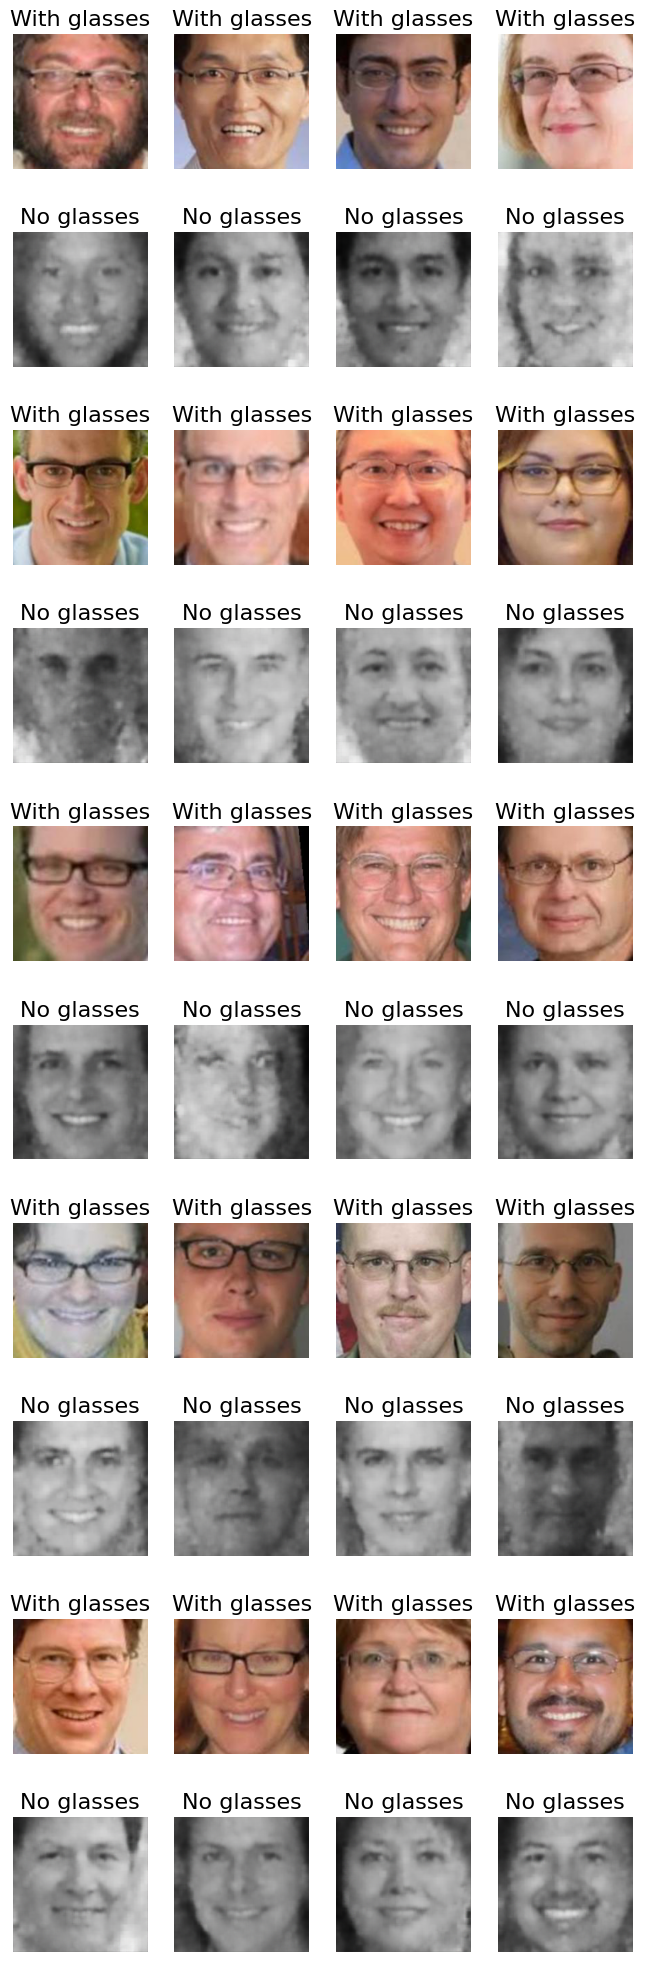

In [ ]:
show_reconstructions(
    img_dir="/content/face_glasses_L/validation/positive",
    encoder=encoder,
    decoder=decoder,
    num_pairs=20
)


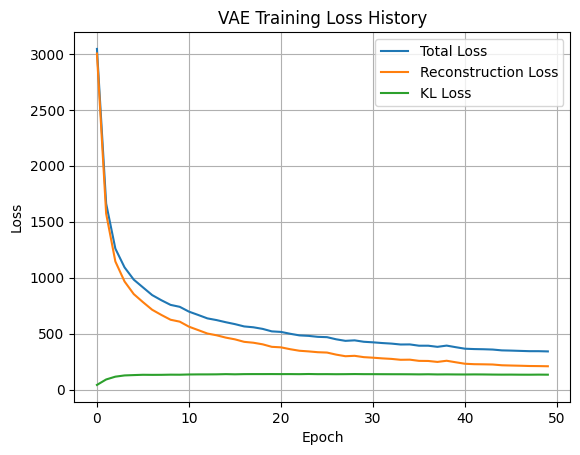

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Total Loss")
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss History")
plt.grid(True)
plt.show()